## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

## Загрузка данных

In [2]:
file_path = "NN_ML.csv"
df = pd.read_csv(file_path)

## Выделение признаков и целевых переменных

In [3]:
X = df[["hf_gibbs_free_energy_ev", "hf_electronic_energy_ev", "hf_entropy_ev", 
        "hf_enthalpy_ev", "hf_dipole_moment_d", "hf_gap_ev"]]

y = df[["dft_gibbs_free_energy_ev", "dft_electronic_energy_ev", "dft_entropy_ev", 
        "dft_enthalpy_ev", "dft_dipole_moment_d", "dft_gap_ev"]]

## Разбиение на train/test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Определение исследуемых моделей

**MultiOutputRegressor используется в моделях LGBMRegressor, Gradient Boosting и CatBoost из-за невозможности предсказать несколько целевых переменных одновременно в этих моделях.**

In [5]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42),
    "LGBMRegressor": MultiOutputRegressor(LGBMRegressor(verbosity=-1, random_state=42)),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    "CatBoost": MultiOutputRegressor(CatBoostRegressor(verbose=0, iterations=500, learning_rate=0.1, depth=6, random_state=42))
}

## Обучим и оценим каждую модель

In [6]:
def calculate_r2(models, results):
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        r2_test = r2_score(y_test, y_pred_test)
        print(f"{name} R²: {r2_test:.4f}")
        results.append((name, r2_test))

In [7]:
results = []
calculate_r2(models, results)

Linear Regression R²: 0.8504
Ridge R²: 0.8498
Lasso R²: 0.8099
Decision Tree R²: 0.7658
Random Forest R²: 0.8452
XGBRegressor R²: 0.8498
LGBMRegressor R²: 0.8532
Gradient Boosting R²: 0.8672
CatBoost R²: 0.8606


**Лучше всего себя показывают последние три модели, в каждой из них мы были вынуждены использовать MultiOutputRegressor. Попробуем применить его к остальным моделям.**

## Попробуем использовать MultiOutputRegressor с остальными моделями

In [8]:
models_mor = {
    "Linear Regression": MultiOutputRegressor(LinearRegression()),
    "Ridge": MultiOutputRegressor(Ridge(alpha=1.0)),
    "Lasso": MultiOutputRegressor(Lasso(alpha=0.1)),
    "Decision Tree": MultiOutputRegressor(DecisionTreeRegressor(random_state=42)),
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    "XGBRegressor": MultiOutputRegressor(XGBRegressor(random_state=42)),
    "LGBMRegressor": MultiOutputRegressor(LGBMRegressor(verbosity=-1, random_state=42)),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    "CatBoost": MultiOutputRegressor(CatBoostRegressor(verbose=0, iterations=500, learning_rate=0.1, depth=6, random_state=42))
}

In [9]:
results_mor = []
calculate_r2(models_mor, results_mor)

Linear Regression R²: 0.8504
Ridge R²: 0.8498
Lasso R²: 0.8099
Decision Tree R²: 0.8011
Random Forest R²: 0.8708
XGBRegressor R²: 0.8493
LGBMRegressor R²: 0.8532
Gradient Boosting R²: 0.8672
CatBoost R²: 0.8606


**Теперь лучше всех остальных себя показывает модель Random Forest.**

## Применим кросс-валидацию к лучшей модели

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(models_mor["Random Forest"], X, y, cv=kf, scoring='r2')
r2_cv = np.mean(scores)
print(r2_cv)

0.8897624268304151


**Кросс-валидация может помочь в подборе гиперпараметров модели и уменьшить дисперсию оценки точности, что особенно полезно, когда у нас ограниченное количество данных.**

## Оценим влияние нормализации данных

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)
scores = cross_val_score(models_mor["Random Forest"], X_scaled, y_scaled, cv=kf, scoring='r2')
r2_cv_scaled = np.mean(scores)
print(r2_cv_scaled)

0.8901702357109414


**Нормализация данных положительно сказалась на точности модели.**

## Выберем лучшую модель

**Как выяснилось, лучшей из исследуемых моделей является модель Random Forest. Также была исследована эффективность этой модели в сочетании с кросс-валидацией и нормализацией, что также подняло значение ее точности.**

## Вывод

**Для увеличения эффективности при работе с такого рода маленькими датасетами (на 100-1000 примеров) в контексте машинного обучения следует:**

1. **Перебрать доступные модели и выбрать самую точную (в нашем случае лучшей оказалась ансамблевая модель, что делает использование ансамблиевых методов машинного обучения приоритетными).**
2. **Использовать MultiOutputRegressor (при 2-х и более мерных целевых данных).**
3. **Применять кросс-валидацию.**
4. **Нормализовывать данные.**

## Построение графиков для презентации

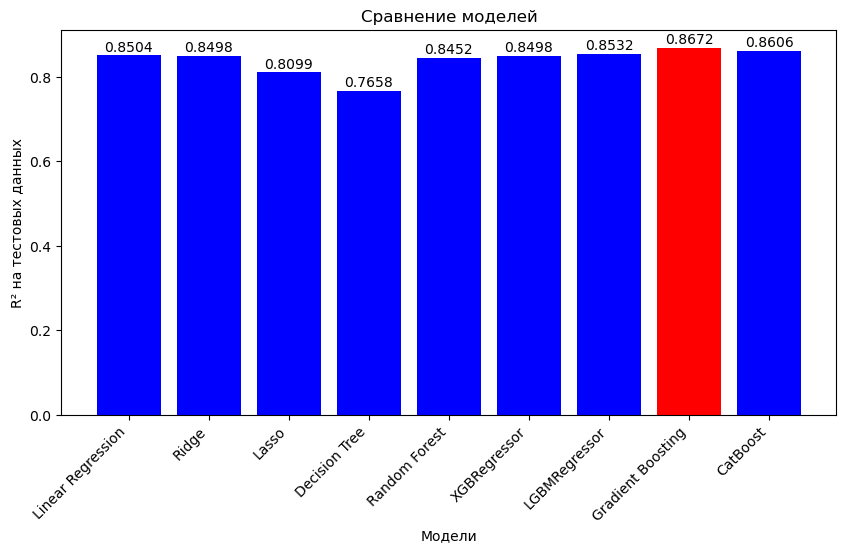

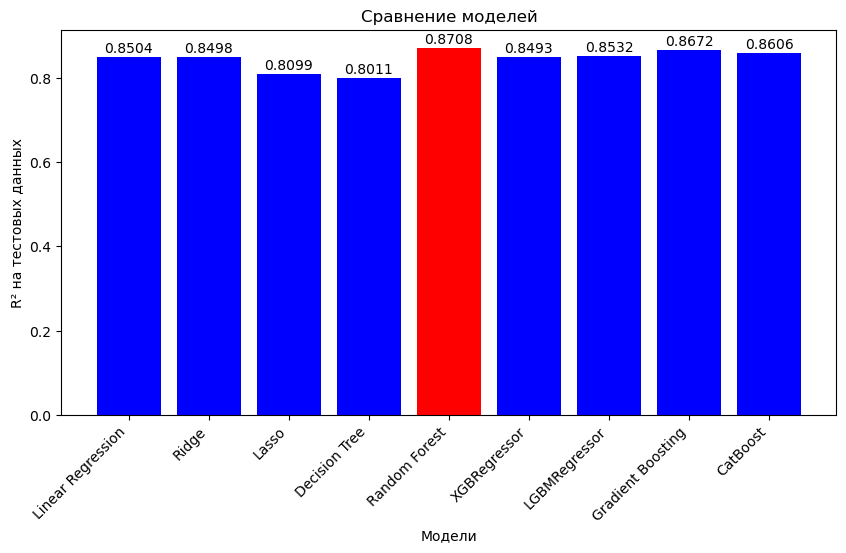

In [27]:
def plot_results(results):
    # Разбираем данные
    names, scores = zip(*results)
    
    # Определяем лучший результат
    max_score = max(scores)
    colors = ['red' if score == max_score else 'blue' for score in scores]
    
    # Создаем диаграмму
    plt.figure(figsize=(10, 5))
    plt.bar(names, scores, color=colors)
    
    # Подписываем оси
    plt.xlabel("Модели")
    plt.ylabel("R² на тестовых данных")
    plt.title("Сравнение моделей")
    
    # Добавляем значения над столбцами
    for i, score in enumerate(scores):
        plt.text(i, score + 0.01, f'{score:.4f}', ha='center', fontsize=10)
    
    # Показываем диаграмму
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_results(results)
plot_results(results_mor)

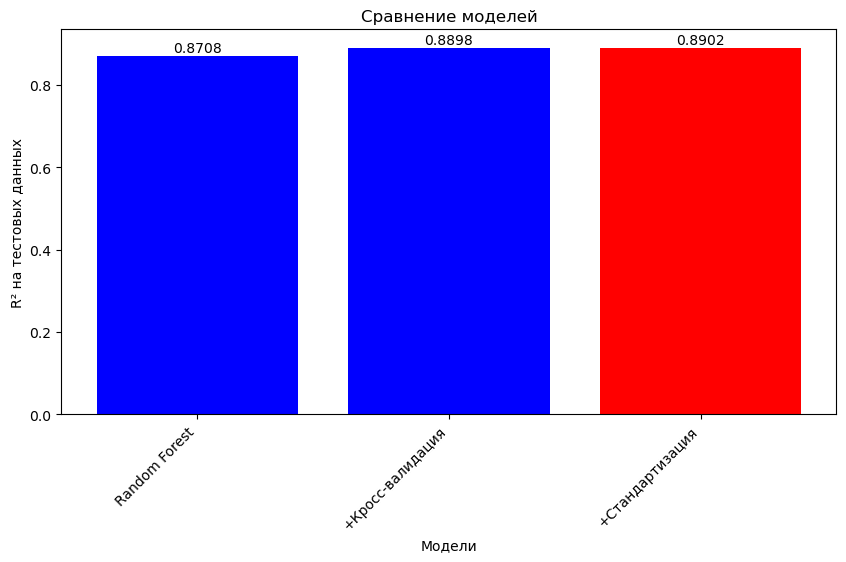

In [28]:
best_mor = max(results_mor, key=lambda x: x[1])
results_cv_scaled = [best_mor, ("+Кросс-валидация", r2_cv), ("+Стандартизация", r2_cv_scaled)]
plot_results(results_cv_scaled)